In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


%matplotlib inline

In [11]:
# Copying some boilerplate from the network analysis notebook

movie_df = pd.read_csv('movie_df.csv', index_col=0)
crew_df = pd.read_csv('crew_df.csv', index_col=0)
cast_df = pd.read_csv('cast_df.csv', index_col=0)

movie_df = movie_df[movie_df.id > 0]
movie_df = movie_df[movie_df.original_title.str.len() > 0]

crew_df = crew_df[crew_df.id > 0]
cast_df = cast_df[cast_df.id > 0]

cast_df = cast_df[cast_df.m_id.isin(list(movie_df[movie_df.id >= 0].id.astype(int)))]
crew_df = crew_df[crew_df.m_id.isin(list(movie_df[movie_df.id >= 0].id.astype(int)))]

rating_df = pd.read_csv("data.tsv",  sep='\t')

In [262]:
movie_df['profit'] = movie_df['revenue'] - movie_df['budget']

In [99]:
cast_df[cast_df.order <= 5].name.value_counts()

Samuel L. Jackson    94
Robert De Niro       90
Nicolas Cage         87
Bruce Willis         85
Frank Welker         79
                     ..
Sean Clement          1
Danielle Mason        1
Thoms Lepera          1
Imani Byers           1
Mary Collinson        1
Name: name, Length: 49135, dtype: int64

In [264]:
# give actor as an input and get the dataframe with name of the movie added in and the ratings 
# idk what else we'd need from movie, but maybe add some more later

billing_limit = 5
actor = 'Nicolas Cage'

tmp = pd.merge(cast_df[cast_df.name.str.contains(actor, na=False) & (cast_df.order <= billing_limit)], 
         movie_df[['id', 'original_title', 'revenue', 'vote_average', 'vote_count', 'budget', 'imdb_id','release_date',
                   'profit']],
         left_on='m_id', right_on='id', how='inner', suffixes=['_actor', '_movie'])

df = pd.merge(tmp, rating_df, left_on='imdb_id', right_on='tconst')

#inherently we're trying to do shit in order so
df.sort_values('release_date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape[0])

87


In [265]:
# averageRating and numVotes are the ones from imdb
# vote_average and vote_count are the versions from tmdb
# in general tmdb is less movie nerd shit, fucking space jam the next generation has some unacceptaly high score

window = 10 

# Temporary fix till I find a way to get around the fact that he released multiple movies on the same day
df = df.drop_duplicates(subset=['release_date'], keep='last')

df['moving_imdb'] = df.averageRating.rolling(window=window).mean()
df['moving_tmdb'] = df.vote_average.rolling(window=window).mean()
df['std_imdb'] = df.averageRating.rolling(window=window).std()
df['std_tmdb'] = df.vote_average.rolling(window=window).std()

In [277]:
df['rating_upper'] = df['moving_imdb'] + df['std_imdb']
df['rating_lower'] = df['moving_imdb'] - df['std_imdb']

df['scaled_imdb_votes'] = (df['numVotes'] / df['numVotes'].max())
df['scaled_imdb_votes_color'] = df['scaled_imdb_votes'] * 500

df['scaled_profit'] = (df['profit'] / df['profit'].max())
df['scaled_profit_color'] = (df['scaled_profit'] + df['scaled_profit'].min() + 1) * 500


# Labels for which movies we wanna graph

top_movies = df.sort_values('scaled_imdb_votes', ascending=False)[['release_date', 'original_title', 'averageRating']].head(10)
# make sure the most and least popular movies, as well as the first and last movies are in the dataframe

first_movie = df.sort_values('release_date', ascending=False)[['release_date', 'original_title', 'averageRating']].head(1)
last_movie = df.sort_values('release_date', ascending=False)[['release_date', 'original_title', 'averageRating']].tail(1)

best_movie = df.sort_values('averageRating', ascending=False)[['release_date', 'original_title', 'averageRating']].head(1)
worst_movie = df.sort_values('averageRating', ascending=False)[['release_date', 'original_title', 'averageRating']].tail(1)

movie_labels = pd.concat([top_movies, first_movie, last_movie, best_movie, worst_movie]).drop_duplicates()

In [278]:
start_time = df.release_date.min()[0:4]
end_time = int(df.release_date.max()[0:4]) + 1

date_start = pd.date_range(start=df.release_date.min()[0:4], end=str(end_time), freq='Y')[0]
date_end = pd.date_range(start=df.release_date.min()[0:4], end=str(end_time), freq='Y')[-1]

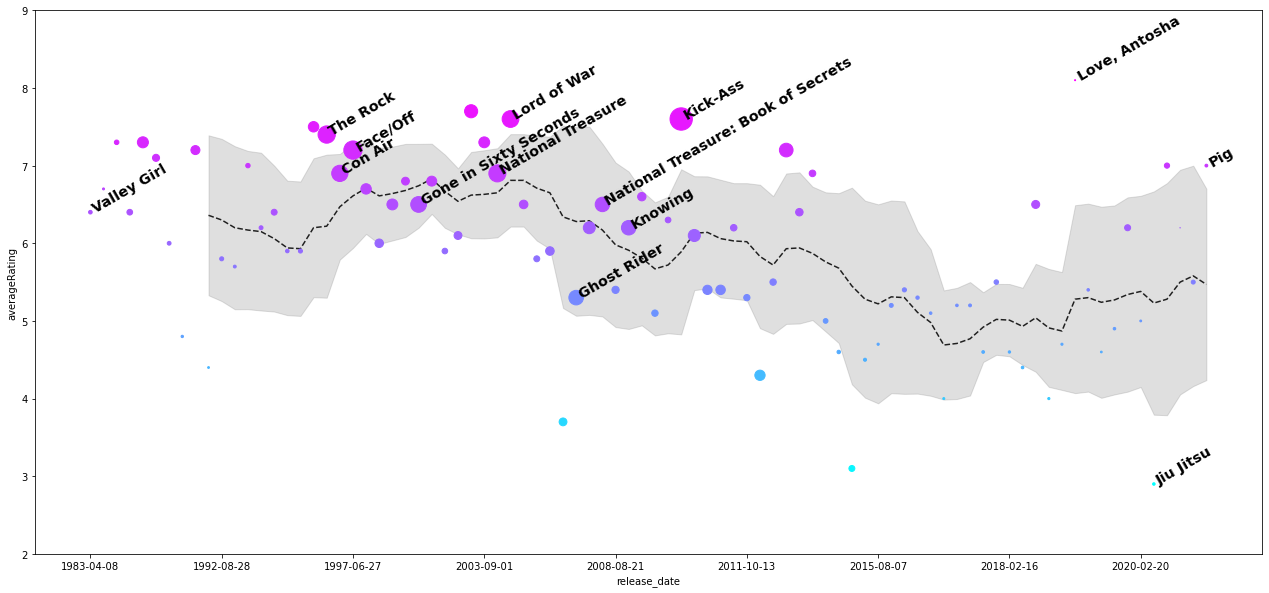

In [279]:
graph_df = df[['release_date','moving_imdb','rating_upper', 
               'rating_lower', 'averageRating']].set_index('release_date')

# ok I fucked something up, but this defines the plot area correctly so cheap out for a second and write shit code till you fix it

ax = graph_df.moving_imdb.plot(figsize=[22,10], 
                               ylim=[np.floor(graph_df.averageRating.min()), 
                                     np.ceil(graph_df.averageRating.max())], 
                               color='black', style='--', use_index=True, zorder=False
                               ) 

plt.fill_between(graph_df.index, graph_df['rating_lower'], graph_df['rating_upper'], interpolate=False, color='grey', alpha=0.25)

# graph_df['averageRating'].plot(kind='line', ax=ax)

df.plot.scatter(x='release_date', y='averageRating', s='scaled_imdb_votes_color', c='averageRating', 
                cmap='cool', colorbar=False, ax=ax)

for index, row in movie_labels.iterrows():
    #print(row['c1'], row['c2'])
    plt.text(row['release_date'], row['averageRating'], row['original_title'], 
             color='black', fontsize='x-large', fontweight='bold', rotation=30)
    
#ax.xaxis.set_major_locator(mdates.AutoDateFormatter())

In [286]:
def full_graph_generation(actor='Nicolas Cage', billing_limit = 5, window=10):
        # give actor as an input and get the dataframe with name of the movie added in and the ratings 
        # idk what else we'd need from movie, but maybe add some more later

        # Referencing globals in a function?! Yeah, I'm an animal
        tmp = pd.merge(cast_df[cast_df.name.str.contains(actor, na=False) & (cast_df.order <= billing_limit)], 
                 movie_df[['id', 'original_title', 'revenue', 'vote_average', 'vote_count', 'budget', 'imdb_id','release_date','profit']],
                 left_on='m_id', right_on='id', how='inner', suffixes=['_actor', '_movie'])

        df = pd.merge(tmp, rating_df, left_on='imdb_id', right_on='tconst')

        #inherently we're trying to do shit in order so
        df.sort_values('release_date', ascending=True, inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        # averageRating and numVotes are the ones from imdb
        # vote_average and vote_count are the versions from tmdb
        # in general tmdb is less movie nerd shit, fucking space jam the next generation has some unacceptaly high score

        # Temporary fix till I find a way to get around the fact that he released multiple movies on the same day
        df = df.drop_duplicates(subset=['release_date'], keep='last')

        df['moving_imdb'] = df.averageRating.rolling(window=window).mean()
        df['moving_tmdb'] = df.vote_average.rolling(window=window).mean()
        df['std_imdb'] = df.averageRating.rolling(window=window).std()
        df['std_tmdb'] = df.vote_average.rolling(window=window).std()
        
        df['rating_upper'] = df['moving_imdb'] + df['std_imdb']
        df['rating_lower'] = df['moving_imdb'] - df['std_imdb']

        df['scaled_imdb_votes'] = (df['numVotes'] / df['numVotes'].max())
        df['scaled_imdb_votes_color'] = df['scaled_imdb_votes'] * 500
        
        df['scaled_profit'] = (df['profit'] / df['profit'].max())
        df['scaled_profit_color'] = (df['scaled_profit'] + df['scaled_profit'].min() + 0.1) * 500


        # Labels for which movies we wanna graph

        top_movies = df.sort_values('scaled_imdb_votes', ascending=False)[['release_date', 'original_title', 'averageRating']].head(10)
        # make sure the most and least popular movies, as well as the first and last movies are in the dataframe

        first_movie = df.sort_values('release_date', ascending=False)[['release_date', 'original_title', 'averageRating']].head(1)
        last_movie = df.sort_values('release_date', ascending=False)[['release_date', 'original_title', 'averageRating']].tail(1)

        best_movie = df.sort_values('averageRating', 
                                    ascending=False)[['release_date', 'original_title', 'averageRating']].head(3)
        worst_movie = df.sort_values('averageRating', 
                                     ascending=False)[['release_date', 'original_title', 'averageRating']].tail(3)
        
        most_obscure = df.sort_values('numVotes', 
                                     ascending=False)[['release_date', 'original_title', 'averageRating']].tail(2)
        
        most_popular = df.sort_values('numVotes', 
                                     ascending=False)[['release_date', 'original_title', 'averageRating']].head(2)

        movie_labels = pd.concat([top_movies, first_movie, last_movie, 
                                  best_movie, worst_movie, most_obscure,
                                  most_popular]).drop_duplicates()

        
        ### ACTUAL GRAPH SECTION
        graph_df = df[['release_date','moving_imdb','rating_upper', 
               'rating_lower', 'averageRating']].set_index('release_date')

        plt.figure(facecolor='white')
        
        ax = graph_df.moving_imdb.plot(figsize=[22,10], 
                                       ylim=[np.floor(graph_df.averageRating.min()), 
                                             np.ceil(graph_df.averageRating.max())], 
                                       color='black', style='--', use_index=True, zorder=False,
                                       title=actor
                                       ) 

        plt.fill_between(graph_df.index, graph_df['rating_lower'], graph_df['rating_upper'], interpolate=False, color='grey', alpha=0.25)

        # graph_df['averageRating'].plot(kind='line', ax=ax)

        df.plot.scatter(x='release_date', y='averageRating', s='scaled_profit_color', c='averageRating', 
                        cmap='cool', colorbar=False, ax=ax)

        for index, row in movie_labels.iterrows():
            #print(row['c1'], row['c2'])
            plt.text(row['release_date'], row['averageRating'], row['original_title'], 
                     color='black', fontsize='x-large', fontweight='bold', rotation=30)
            
        plt.xlabel('Release Date', fontdict={'fontsize':'xx-large'})
        plt.ylabel('Average Rating', fontdict={'fontsize':'xx-large'})
        
        plt.title("{}'s Career Trajectory".format(actor), fontdict={'fontsize':'xx-large', 'fontweight':'bold'})

        return ax

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


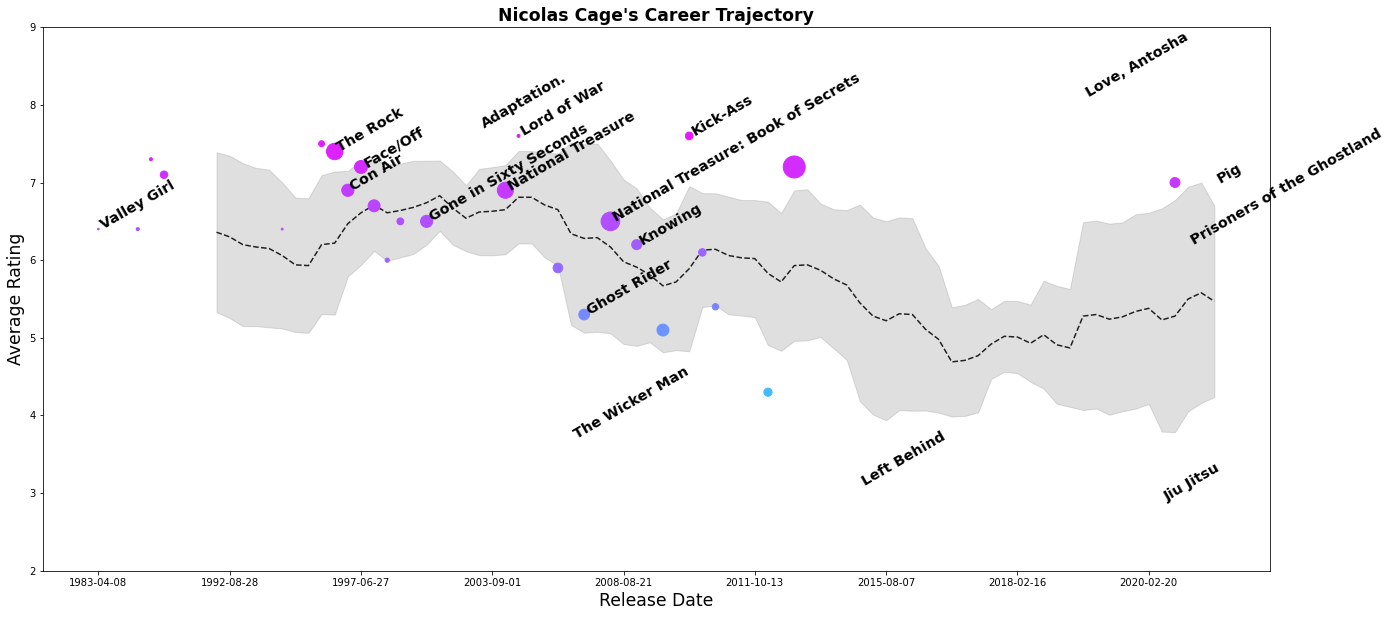

In [287]:
actor = 'Nicolas Cage'

tmp = full_graph_generation(actor)
plt.savefig('{}_career.png'.format(actor))

In [250]:
%pwd

'C:\\Users\\Nick\\MovieImpact'

<AxesSubplot:xlabel='release_date', ylabel='averageRating'>

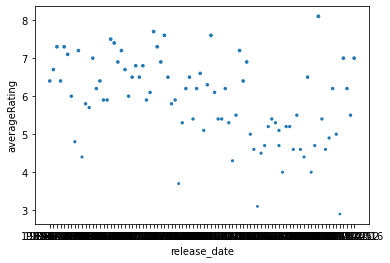

In [90]:
df.plot.scatter(x='release_date', y='averageRating', s='averageRating')